In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from aux import loadmat_h5
from disp import set_font_size

TUNING_FILE = 'data/simple/ipi_freq_timecourses.npy'
CELL_FILE = 'data/christa/VLP_knownAUD_neurons_copiedFromFlyWireDatabase_20200617.xlsx'
W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'

FPS = 8.5

In [2]:
tuning_data = np.load(TUNING_FILE, allow_pickle=True)[0]

ipi = tuning_data['ipi']
ipi_rsps = tuning_data['ipi_rsps_means']

freq = tuning_data['freq']
freq_rsps = tuning_data['freq_rsps_means']

In [3]:
cell_df = pd.read_excel(CELL_FILE, engine='openpyxl')
labels = np.array(cell_df['short name'])
line_ids = np.array(cell_df['lineID for IPI/Freq tuning curves'])
signs = np.array(cell_df['Eckstein NT classification numeric'])

label2line = {label: line_id for label, line_id in zip(labels, line_ids)}
label2sign = {label: sign for label, sign in zip(labels, signs)}

In [4]:
w_th = 5
w_data = loadmat_h5(W_FILE)
w_raw = w_data['cxns_noDup']
w = w_raw.copy()
w[w_raw < w_th] = 0
w[np.isnan(w)] = 0
labels_w = w_data['neuronNames'][:, 0]

# add sign
sign_mat = np.zeros(w.shape)  # note this zeroes any weights without signs attached
for cl, label in enumerate(labels_w):
    if label in label2sign and not np.isnan(label2sign[label]):
        sign_mat[cl, :] = label2sign[label]
            
w = w*sign_mat  # multiply w by signs

In [5]:
for label in labels_w:  # fill any missing labels with nan
    if label not in label2line:
        label2line[label] = np.nan

In [6]:
def get_ipi_timecourses(label): # get idx
    line_idx = label2line[label]
    if not np.isnan(line_idx): 
        rsp = ipi_rsps[int(round(line_idx - 1))]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(ipi), 1))], axis=1)
        else:
            return rsp
    else:
        print(f'No ipi responses for cell {label}')
        return None

def get_freq_timecourses(label): # get idx
    line_idx = label2line[label]
    if not np.isnan(line_idx): 
        rsp = freq_rsps[int(line_idx - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(freq), 1))], axis=1)
        else:
            return rsp
    else:
        print(f'No freq responses for cell {label}')
        return None

$$\tau \frac{dx_i}{dt} = -x_i + \sum_j W_{ij} x_j$$

No IPI responses for cell 36007_L1
No IPI responses for cell 36007_L2
No IPI responses for cell 36007_L3
No IPI responses for cell 36007_R1
No IPI responses for cell 36007_R2
No IPI responses for cell 36007_R3
No IPI responses for cell 36007_R4
No IPI responses for cell 36007_R5
No IPI responses for cell 36007_R6


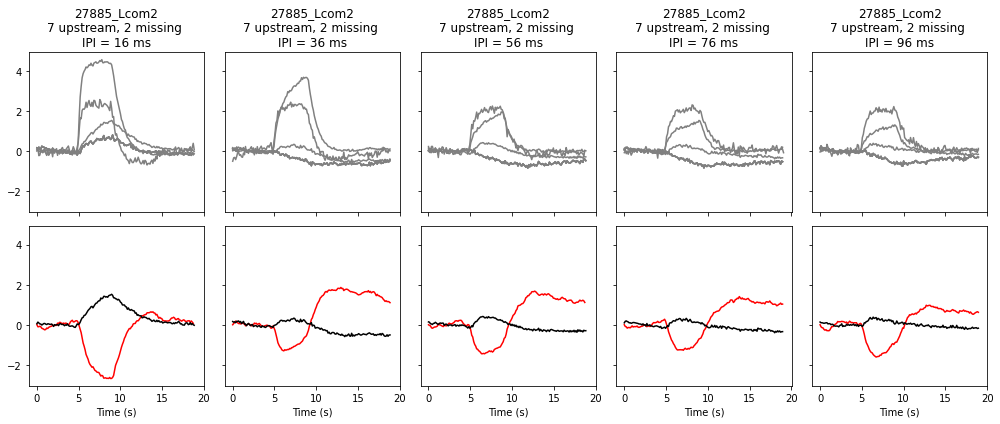

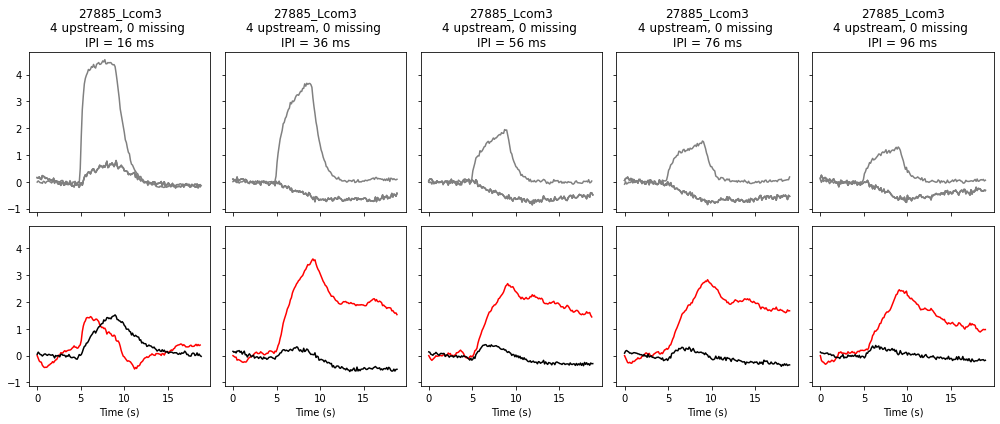

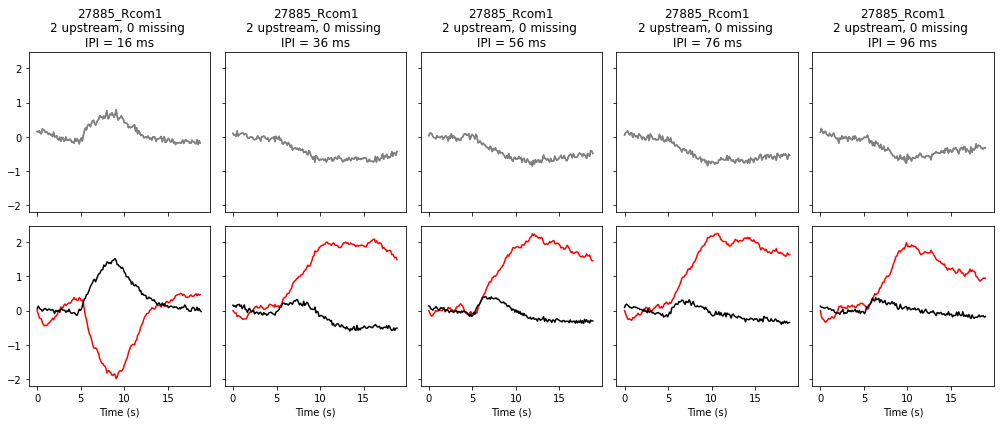

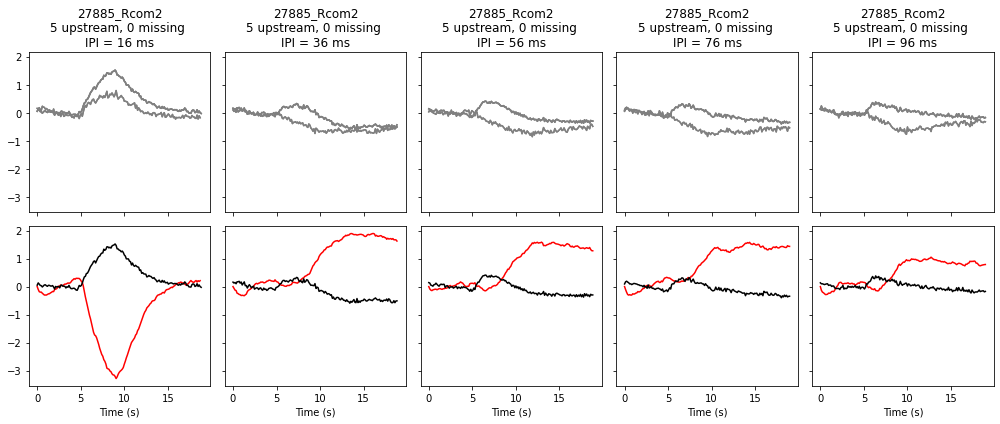

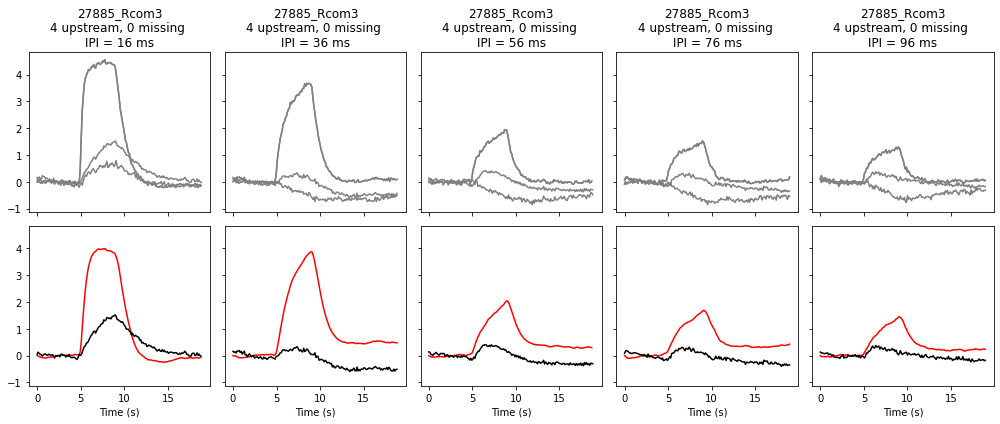

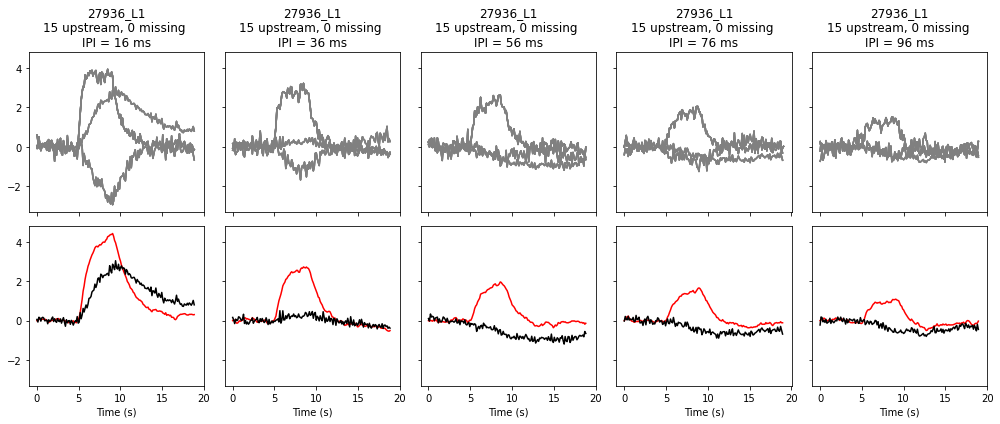

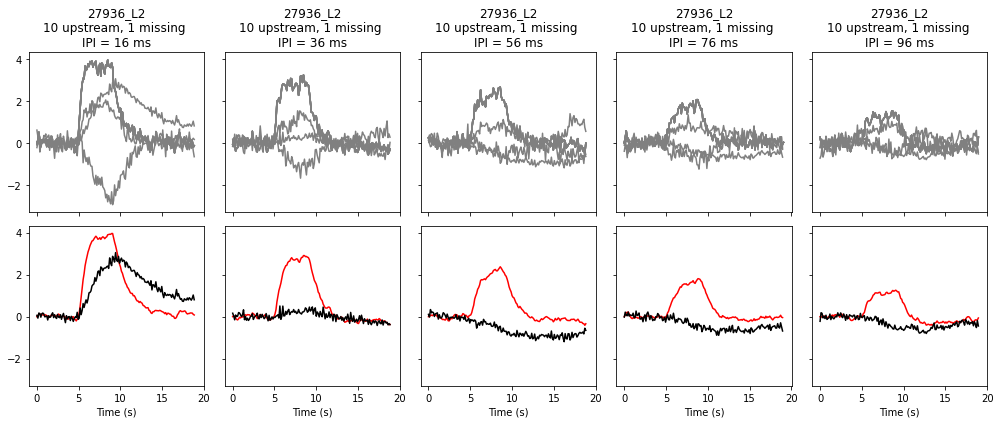

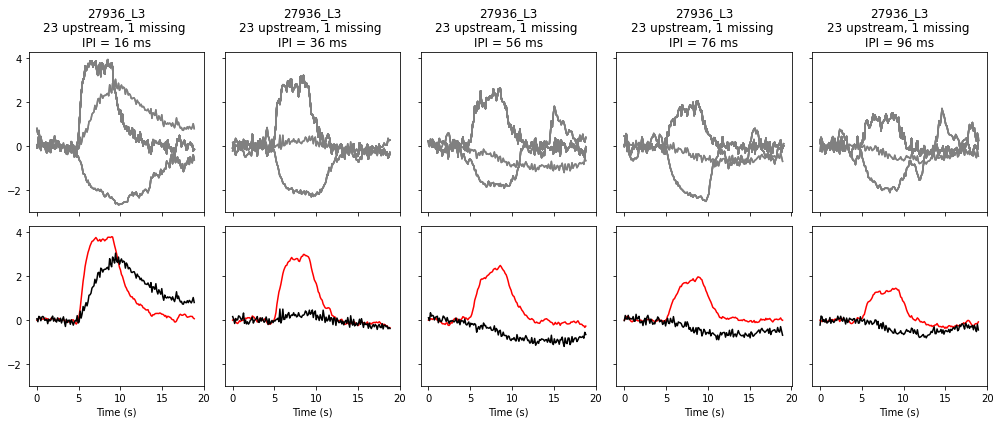

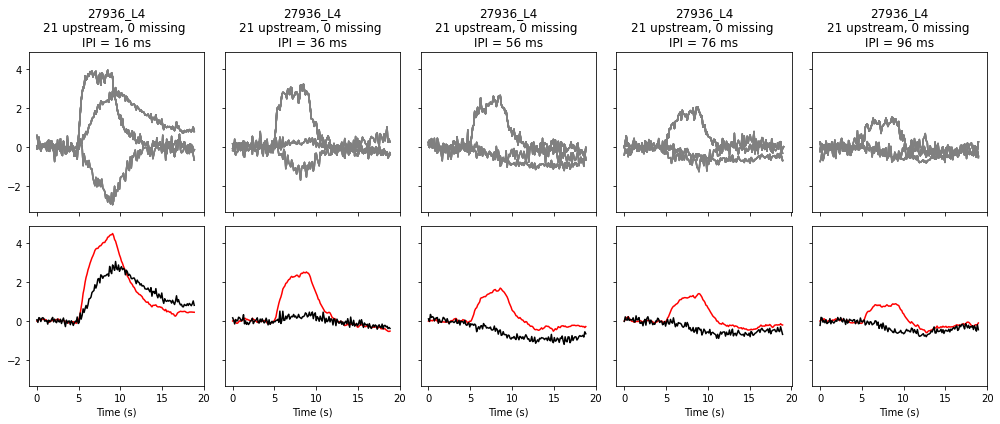

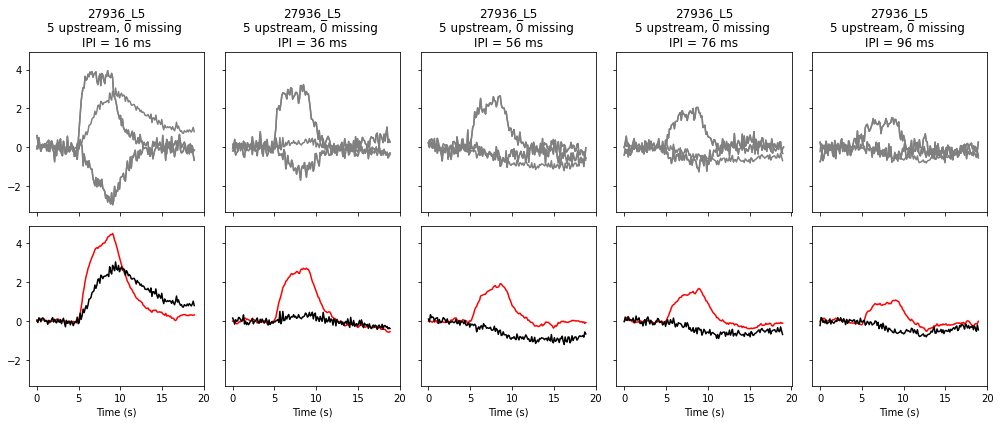

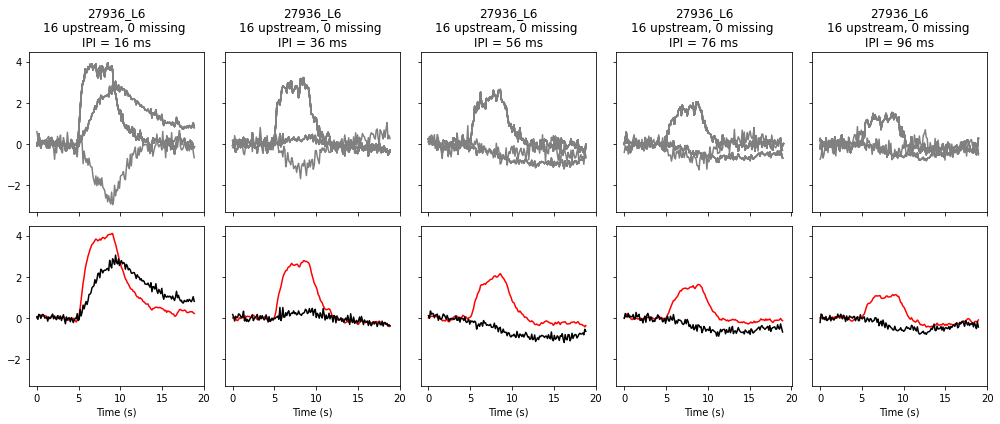

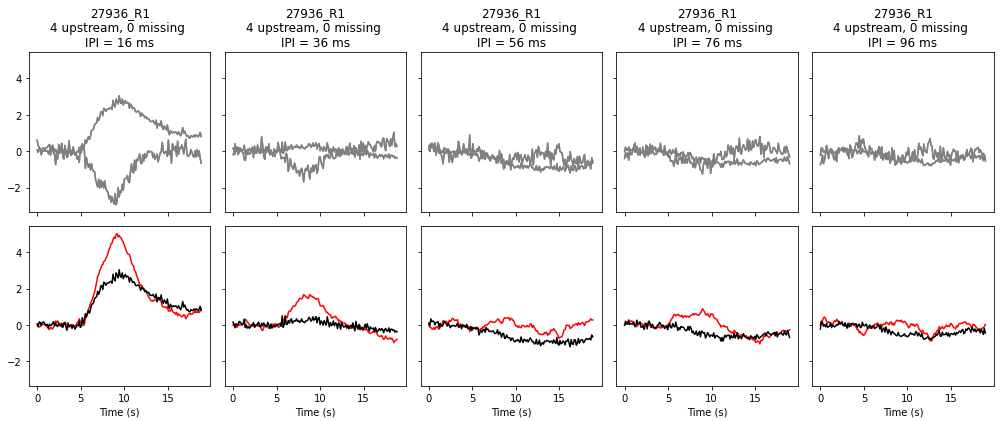

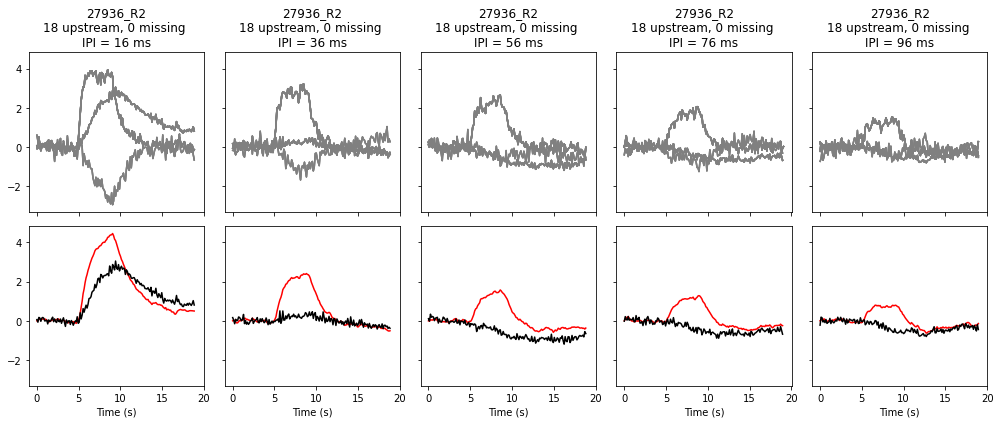

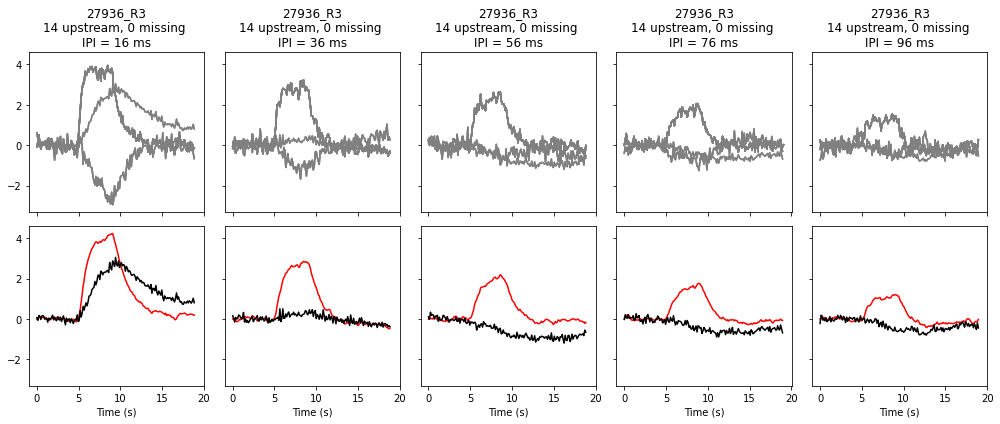

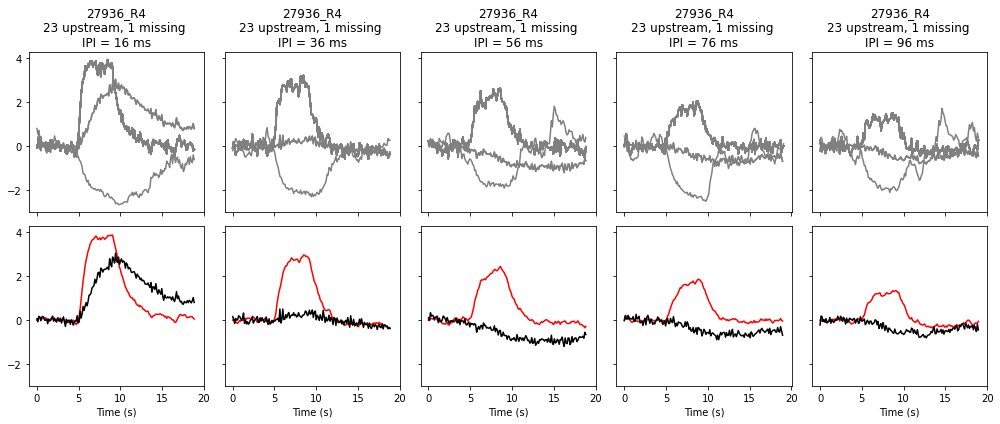

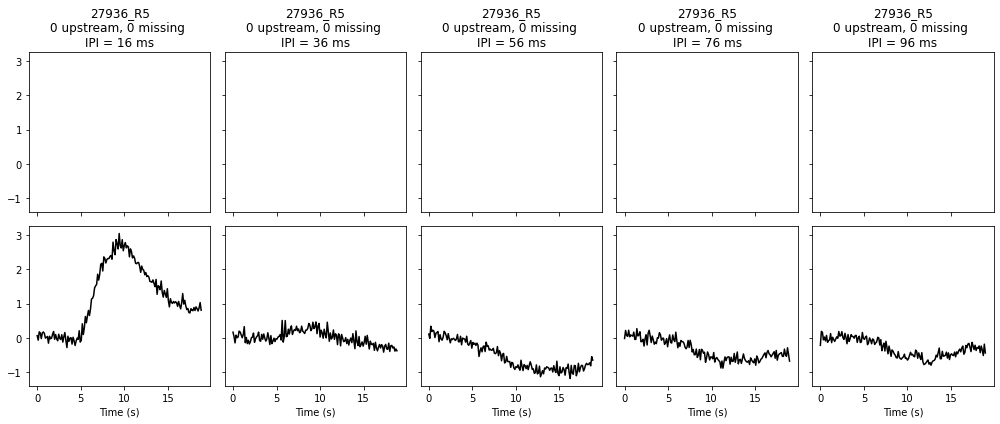

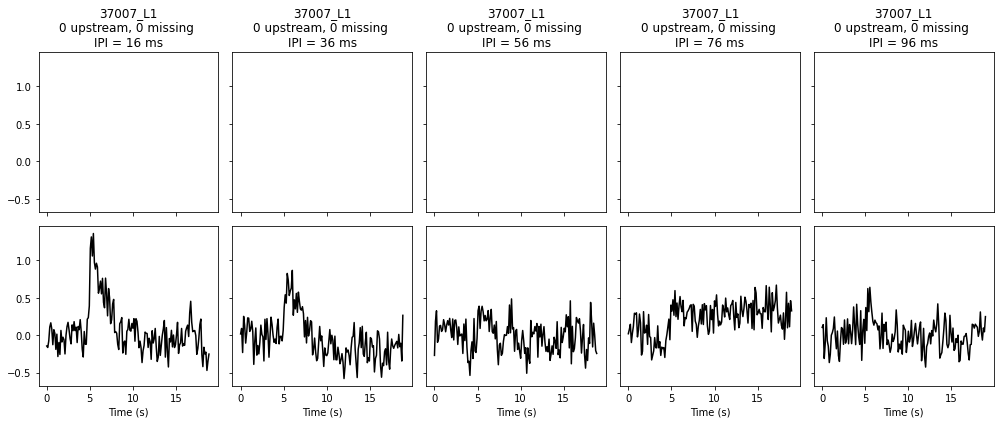

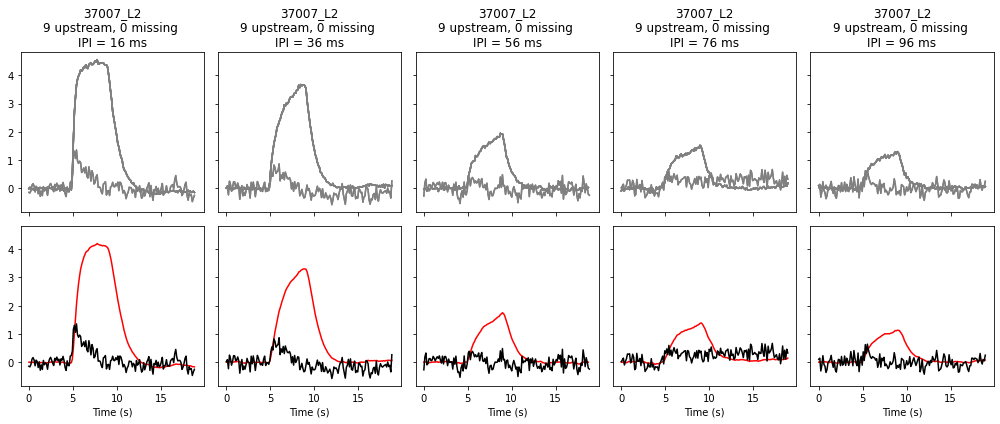

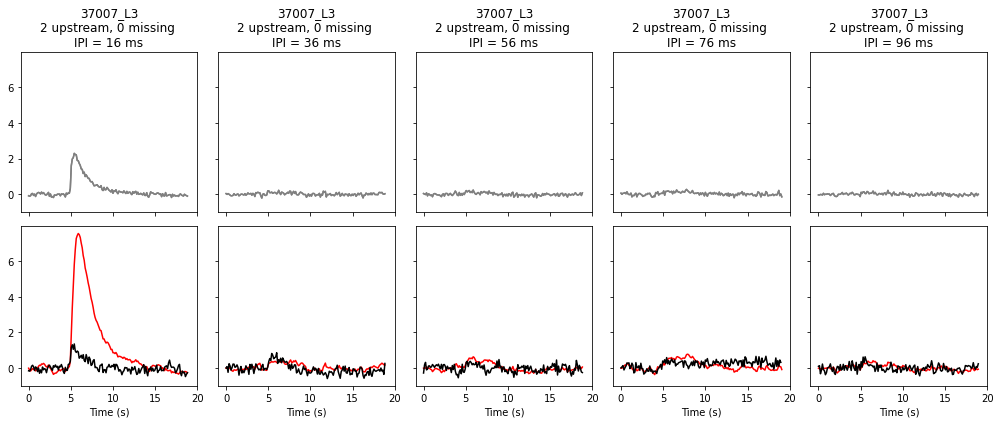

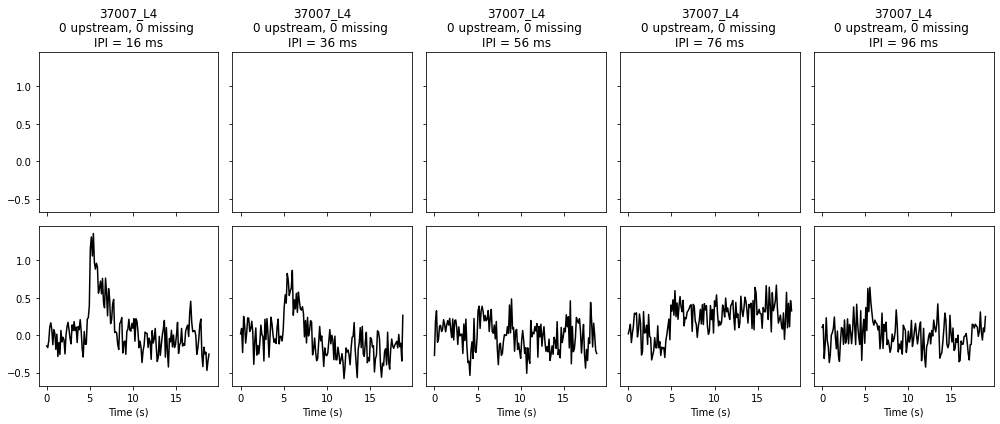

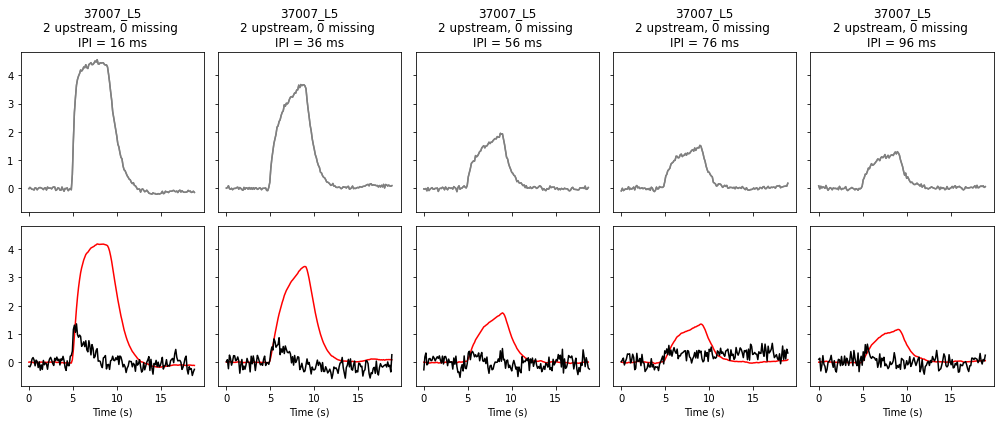

In [19]:
# IPI tuning
DT = 1/FPS
TAU = .5
INRN = np.arange(200, 230)
INRN_PLOT = np.arange(200, 230)

labels_up_valid_all = {}
labels_up_missing_all = {}

for inrn in INRN:
    label = labels_w[inrn]
    
    t = np.arange(164)/FPS

    if np.isnan(label2line[label]):
        print(f'No IPI responses for cell {label}')
        continue
        
    # upstream inputs
    iup = w[:, inrn].nonzero()[0]  # idxs relative to w and labels_w
    w_up = w[iup, inrn]  # weights
    labels_up = labels_w[iup]  # labels
    lines_up = np.array([label2line[label_up] for label_up in labels_up])
    
    # subset of upstream inputs with tuning curve data (mask for previous 4 arrays)
    mvalid = ~np.isnan(lines_up)
    assert len(iup) == len(w_up) == len(labels_up) == len(lines_up)
    
    labels_up_valid = labels_up[mvalid]  # labels of upstream cells w/ IPI data
    labels_up_missing = labels_up[~mvalid]  # labels of upstream cells w/o IPI data
    
    labels_up_valid_all[label] = labels_up_valid.copy()
    labels_up_missing_all[label] = labels_up_missing.copy()
    
    # weights corresponding to valid upstream labels
    w_up_valid = w_up[mvalid]
    
    # downstream neuron ipi time courses
    rsps_true = get_ipi_timecourses(label)

    # upstream neuron ipi time courses
    rsps_up_all = [get_ipi_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each IPI
    rsps_model = []
    for cipi, ipi_ in enumerate(ipi):
        # get array of upstream neuron activities for this IPI
        rsp_up = np.array([rsps_up[cipi, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        if len(rsp_up) > 0:
            r[0] = 0

            for ct, t_ in enumerate(t[1:], 1):
                dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
                r[ct] = r[ct-1] + dr
            
        rsps_model.append(r.copy())
        
    rsps_model = np.array(rsps_model)
    rsps_model /= np.nanstd(rsps_model)
    
    # input currents for each IPI and true vs modeled output current for each IPI
    if inrn in INRN_PLOT:
        fig, axs = plt.subplots(2, 5, figsize=(14, 6), sharex=True, sharey=True, tight_layout=True)
        
        for cax, (ax, ipi_) in enumerate(zip(axs[0, :], ipi)):
            # plot all upstream responses (i.e. inputs) colored by weight
            rsp_up = np.array([rsps_up[cax, :] for rsps_up in rsps_up_all])
            assert len(rsp_up) == len(w_up_valid)
            
            for rsp_up_, w_ in zip(rsp_up, w_up_valid):
                ax.plot(t, rsp_up_, c='gray')
                
            ax.set_title(f'{label}\n{len(labels_up_valid)} upstream, {len(labels_up_missing)} missing \nIPI = {ipi_} ms')
            
        for cax, (ax, ipi_) in enumerate(zip(axs[1, :], ipi)):
            ax.plot(t, rsps_model[cax], c='r')
            ax.plot(t, rsps_true[cax], c='k')
            
            ax.set_xlabel('Time (s)')

In [10]:
for cnrn, label in enumerate(labels_w):
    print(cnrn, label, label2line[label])

0 A1_L1 nan
1 A1_L2 nan
2 A1_L3 nan
3 A1_R1 nan
4 A1_R2 nan
5 A2_L 10.0
6 A2_R 10.0
7 B1-1_L1 15.0
8 B1-1_L2 15.0
9 B1-1_L3 15.0
10 B1-1_L4 15.0
11 B1-1_L5 15.0
12 B1-1_L6 15.0
13 B1-1_R1 15.0
14 B1-1_R2 15.0
15 B1-1_R3 15.0
16 B1-1_R4 15.0
17 B1-1_R5 15.0
18 B1-1_R6 15.0
19 B1-2_L1 15.0
20 B1-2_L2 15.0
21 B1-2_L3 15.0
22 B1-2_L4 15.0
23 B1-2_L5 15.0
24 B1-2_L6 15.0
25 B1-2_L7 15.0
26 B1-2_L8 15.0
27 B1-2_L9 15.0
28 B1-2_R1 15.0
29 B1-2_R2 15.0
30 B1-2_R3 15.0
31 B1-2_R4 15.0
32 B1-2_R5 15.0
33 B1-2_R6 15.0
34 B1-2_R7 15.0
35 B1-2_R8 15.0
36 B1-3_L1 15.0
37 B1-3_L2 15.0
38 B1-3_L3 15.0
39 B1-3_L4 15.0
40 B1-3_L5 15.0
41 B1-3_R1 15.0
42 B1-3_R2 15.0
43 B1-3_R3 15.0
44 B1-3_R4 15.0
45 B1-3_R5 15.0
46 B1-4_L1 15.0
47 B1-4_L2 15.0
48 B1-4_L3 15.0
49 B1-4_L4 15.0
50 B1-4_L5 15.0
51 B1-4_L6 15.0
52 B1-4_L7 15.0
53 B1-4_L8 15.0
54 B1-4_L9 15.0
55 B1-4_R1 15.0
56 B1-4_R2 15.0
57 B1-4_R3 15.0
58 B1-4_R4 15.0
59 B1-4_R5 15.0
60 B1-4_R6 15.0
61 B1-4_R7 15.0
62 B1-4_R8 15.0
63 B1-u_L1 15.0
64 B1-u